#Imports

In [ ]:
#Importing all the required packages
import gym
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from gym import spaces
from operator import add
import torch.optim as optim
from collections import deque
import torch.nn.functional as F
from google.colab import widgets
from collections import namedtuple, deque
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

#Environment from previous code

In [ ]:
class Deterministic_Environment(gym.Env):
    def __init__(self, max_timesteps):
        #Defining observation space (rows x columns) of the grid
        self.observation_space = spaces.Discrete(16)
        #Defining the number of possible actions
        self.action_space = spaces.Discrete(4)
        #Setting the max number of timesteps
        self.max_timesteps = 12
            
    def reset(self):
        grid_size = (4,4)
        #Setting initial values as 0
        self.timestep = 0
        self.reward = 0      
        self.cumulative_rewards = 0
        #Initial position of agent
        self.agent_pos = np.array([0, 0])
        #Positions of silver coins
        self.sil_pos = np.array([[0,1],[3,2],[2,0]])
        #Positions of devils
        self.dev_pos = np.array([[2,3],[3,1]])
        #Position of gold reward
        self.goal_pos = np.array([1, 2])    
        self.state = np.zeros(grid_size)
        self.done = False
        return
    
    def step(self, action):
        grid_size = (4,4)
        if action == 0:
            #Move Left
            self.agent_pos[0] -= 1
        if action == 1:
            #Move Right
            self.agent_pos[0] += 1
        if action == 2:
            #Move Up
            self.agent_pos[1] += 1
        if action == 3:
            #Move Down
            self.agent_pos[1] -= 1
        #Using clip function to keep agent within grid limits
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros(grid_size)
        #Setting rewards
        if (self.agent_pos == self.goal_pos).all():
            self.reward = 50
            self.done = True
            self.reward += 1
        if (np.any(np.all(self.agent_pos == self.sil_pos, axis=1))):
            self.reward = 10        
        if (np.any(np.all(self.agent_pos == self.dev_pos, axis=1))):
            self.reward = -15
        #Summation of rewards to get the total reward
        self.cumulative_rewards += self.reward
        self.timestep += 1
        if not self.done:
            self.done = True if self.timestep >= self.max_timesteps else False
        #Stores all the information of agent and environment in every timestep
        info = "Position of Agent: [" + str(self.agent_pos[0]) + "," + str(self.agent_pos[1]) + "] ; " + "Current Reward: " + str(self.reward) + " ; " + "Cumulative Reward: " + str(self.cumulative_rewards)
        return self.reward, self.done, info

    def get_agent_pos(self):   
        grid = np.zeros((4,4)) 
        for row in range(4):
          for col in range(4):
            if (row == self.agent_pos[0] and col == self.agent_pos[1]):
              grid[row,col] = 1
        grid = grid.flatten()
        return grid
    
    def render(self):
        #Plot size
        fig,ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(0,4)
        ax.set_ylim(0,4)
        plt.grid()
        agent1_pos = False
        goal1_pos = False
        #x and y axes
        plt.xticks([0,1,2,3,4])
        plt.yticks([0,1,2,3,4])
        for sil1_pos in self.sil_pos:
            #Plotting image of silver rewards
            sil = AnnotationBbox(OffsetImage(plt.imread('sil.png'), zoom=0.15), list(map(add, sil1_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(sil)
        for dev1_pos in self.dev_pos:
            #Plotting image of devil
            dev = AnnotationBbox(OffsetImage(plt.imread('dev.png'), zoom=0.18), list(map(add, dev1_pos, [0.5, 0.5])), frameon=False)
            ax.add_artist(dev)
        if not goal1_pos:
            #Plotting image of gold rewards
            goal = AnnotationBbox(OffsetImage(plt.imread('gold.png'), zoom=0.07), list(map(add, self.goal_pos , [0.5, 0.5])), frameon=False)
            ax.add_artist(goal)
        if not agent1_pos:
            #Plotting image of agent
            agent = AnnotationBbox(OffsetImage(plt.imread('age.png'), zoom=0.08), list(map(add, self.agent_pos , [0.5, 0.5])), frameon=False)
            ax.add_artist(agent)

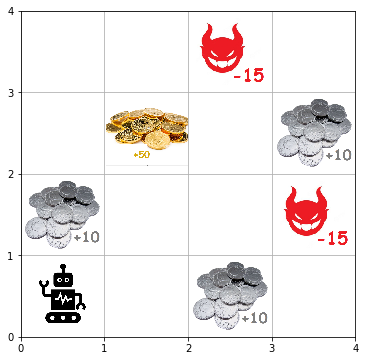

In [ ]:
env = Deterministic_Environment(12) 
env.reset()
env.render()

#DQN Implementation

In [ ]:
#Discount Factor (gamma)
gamma = 0.99
#Mini batch
batch_size = 32
#Learning Rate (alpha)
lr = 0.001
#Final score that needs to be acheived by the agent
goal_score = 470
#Interval of Episodes
log_interval = 10
#Parameters from environment
Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

#Memory Class which we use to store the values
class Memory(object):
    def __init__(self):
        self.memory = deque(maxlen=2000)

    def push(self, state, next_state, action, reward, mask):
        self.memory.append(Transition(state, next_state, action, reward, mask))

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch

#Implementing Sequential Neural Networks
class QNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(QNet, self).__init__()
        #Grabbing input and output values from environment
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        #Linear Network with 2 hidden layers
        self.fc1 = nn.Linear(num_inputs, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, num_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        qvalue = self.fc3(x)
        return qvalue

    #Training the model
    @classmethod
    def train_model(cls, online_net, target_net, optimizer, batch):
        states = torch.stack(batch.state)
        next_states = torch.stack(batch.next_state)
        actions = torch.Tensor(batch.action).float()
        rewards = torch.Tensor(batch.reward)
        masks = torch.Tensor(batch.mask)
        pred = online_net(states).squeeze(1)
        next_pred = target_net(next_states).squeeze(1)
        pred = torch.sum(pred.mul(actions), dim=1)
        #Calculating target for network
        target = rewards + masks * gamma * next_pred.max(1)[0]
        #Using MSE loss function
        loss = F.mse_loss(pred, target.detach())
        #Zero gradient optimiation
        optimizer.zero_grad()
        #calculating backward loss
        loss.backward()
        optimizer.step()
        return loss

    def get_action(self, input):
        qvalue = self.forward(input)
        #Getting action that need to be taken
        _, action = torch.max(qvalue, 1)
        return action.numpy()[0]

def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        return target_net.get_action(state)

def update_target_model(online_net, target_net):
    #Updating target
    target_net.load_state_dict(online_net.state_dict())

def main():
    env = gym.make(env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.n
    print('state size:', num_inputs)
    print('action size:', num_actions)
    #Two neural networks
    online_net = QNet(num_inputs, num_actions)
    target_net = QNet(num_inputs, num_actions)
    update_target_model(online_net, target_net)
    #Adam optimizer
    optimizer = optim.Adam(online_net.parameters(), lr=lr)

    online_net.train()
    target_net.train()
    memory = Memory()
    running_score = 0
    epsilon = 1.0
    steps = 0
    loss = 0
    eps_decay=[]
    scores=[]
    for e in range(1000):
        done = False
        score = 0
        state = env.reset()
        state = torch.Tensor(state)
        state = state.unsqueeze(0)

        while not done:
            steps += 1
            eps_decay.append(epsilon)
            action = get_action(state, target_net, epsilon, env)
            next_state, reward, done, _ = env.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)

            mask = 0 if done else 1
            reward = reward if not done or score == 499 else -1
            #One-hot encoding
            action_one_hot = np.zeros(num_actions)
            action_one_hot[action] = 1
            memory.push(state, next_state, action_one_hot, reward, mask)

            score += reward
            state = next_state
            scores.append(score)
            if steps > 500:
                epsilon -= 0.00005
                epsilon = max(epsilon, 0.1)
                batch = memory.sample(batch_size)
                loss = QNet.train_model(online_net, target_net, optimizer, batch)
                if steps % 100 == 0:
                    update_target_model(online_net, target_net)

        running_score = 0.99 * running_score + 0.01 * score
        if e % log_interval == 0:
            print('{} episode | score: {:.2f} | epsilon: {:.2f}'.format(
                e, running_score, epsilon))
        if running_score > goal_score:
            break
    
    plt.plot(eps_decay, label = "Epsilon Decay")
    plt.xlabel("Episodes")
    plt.ylabel("Epsilon")
    plt.title("Epsilion Decay")
    plt.show()

    plt.plot(scores, label = "Total Scores")
    plt.xlabel("Episodes")
    plt.ylabel("Scores")
    plt.title("Final Score")
    plt.show()

#Applying DQN for CartPole

state size: 4
action size: 2
0 episode | score: 0.18 | epsilon: 1.00
10 episode | score: 1.66 | epsilon: 1.00
20 episode | score: 3.49 | epsilon: 1.00
30 episode | score: 5.86 | epsilon: 0.99
40 episode | score: 7.52 | epsilon: 0.98
50 episode | score: 8.32 | epsilon: 0.97
60 episode | score: 9.40 | epsilon: 0.96
70 episode | score: 10.86 | epsilon: 0.94
80 episode | score: 11.96 | epsilon: 0.93
90 episode | score: 12.98 | epsilon: 0.92
100 episode | score: 13.59 | epsilon: 0.91
110 episode | score: 14.56 | epsilon: 0.89
120 episode | score: 14.87 | epsilon: 0.89
130 episode | score: 15.75 | epsilon: 0.87
140 episode | score: 17.87 | epsilon: 0.85
150 episode | score: 19.73 | epsilon: 0.83
160 episode | score: 20.42 | epsilon: 0.82
170 episode | score: 21.28 | epsilon: 0.80
180 episode | score: 22.89 | epsilon: 0.78
190 episode | score: 24.89 | epsilon: 0.76
200 episode | score: 26.59 | epsilon: 0.74
210 episode | score: 27.82 | epsilon: 0.72
220 episode | score: 29.77 | epsilon: 0.69


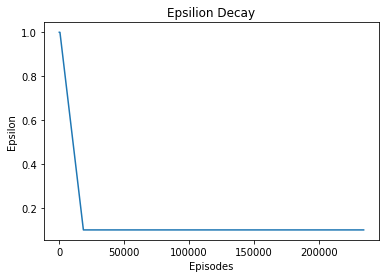

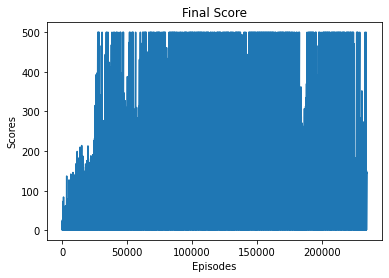

In [ ]:
env_name = 'CartPole-v1'
if __name__=="__main__":
    main()

#Applying DQN for LunarLander

state size: 8
action size: 4
0 episode | score: -0.69 | epsilon: 1.00
10 episode | score: -4.89 | epsilon: 0.98
20 episode | score: -10.94 | epsilon: 0.93
30 episode | score: -13.86 | epsilon: 0.88
40 episode | score: -17.75 | epsilon: 0.83
50 episode | score: -16.24 | epsilon: 0.78
60 episode | score: -16.49 | epsilon: 0.73
70 episode | score: -12.88 | epsilon: 0.67
80 episode | score: -9.05 | epsilon: 0.62
90 episode | score: -5.94 | epsilon: 0.57
100 episode | score: -4.63 | epsilon: 0.47
110 episode | score: 0.80 | epsilon: 0.34
120 episode | score: 9.32 | epsilon: 0.10
130 episode | score: 10.66 | epsilon: 0.10
140 episode | score: 6.44 | epsilon: 0.10
150 episode | score: 13.10 | epsilon: 0.10
160 episode | score: 18.44 | epsilon: 0.10
170 episode | score: 27.35 | epsilon: 0.10
180 episode | score: 36.18 | epsilon: 0.10
190 episode | score: 29.54 | epsilon: 0.10
200 episode | score: 26.77 | epsilon: 0.10
210 episode | score: 29.23 | epsilon: 0.10
220 episode | score: 29.64 | epsi

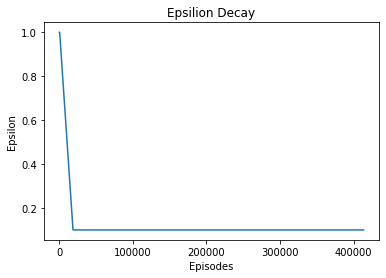

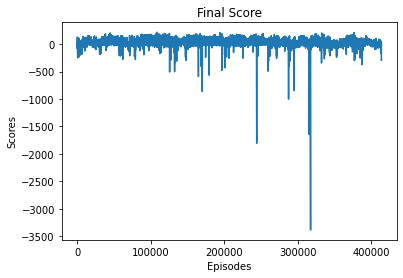

In [ ]:
env_name = 'LunarLander-v2'
if __name__=="__main__":
    main()